<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/classica/clusterizacaoNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
pd.set_option('display.max_rows', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [2]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 2 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [ ]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [8]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ!,:.; ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=ngrams(1,1)) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf( V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processsaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [3]:
dfDados = pd.read_csv('news_integradas.csv')
print(dfDados.shape)

(178229, 8)


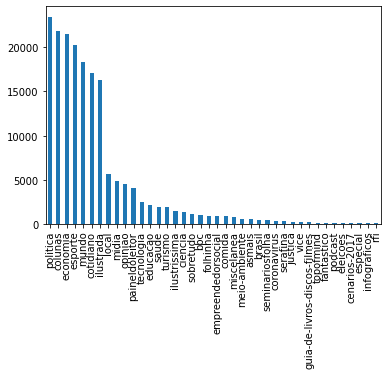

In [4]:
df = dfDados['category'].value_counts()
df =df.head(40)
df.plot.bar()


In [ ]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
linkage = ['ward','complete','single','average']
distancia = ['euclidean', 'manhattan'] #, 'cosine'
d_tsh = [8,10,12]
dictResultado = {}
dictModel = {}

for l in linkage:
  for d in distancia:
    for n in d_tsh:
      if l=='ward' and d!='euclidean':
        continue
      model = AgglomerativeClustering(linkage=l, affinity=d, distance_threshold=n, n_clusters=None)
      model = model.fit(X_tfidf.toarray())
      dictResultado[l + '_' + d + '_' + str(n)] = model.n_clusters_
      dictModel[l + '_' + d + '_' + str(n)] = model


In [ ]:
dictResultado

{'average_euclidean_10': 1,
 'average_euclidean_12': 1,
 'average_euclidean_8': 1,
 'average_manhattan_10': 5398,
 'average_manhattan_12': 4391,
 'average_manhattan_8': 5985,
 'complete_euclidean_10': 1,
 'complete_euclidean_12': 1,
 'complete_euclidean_8': 1,
 'complete_manhattan_10': 5556,
 'complete_manhattan_12': 4642,
 'complete_manhattan_8': 6064,
 'single_euclidean_10': 1,
 'single_euclidean_12': 1,
 'single_euclidean_8': 1,
 'single_manhattan_10': 2612,
 'single_manhattan_12': 1000,
 'single_manhattan_8': 4638,
 'ward_euclidean_10': 5,
 'ward_euclidean_12': 4,
 'ward_euclidean_8': 10}

In [ ]:
model = dictModel['ward_euclidean_12']
print('nro cluster:',model.n_clusters_)
distancia = model.distances_
print('distância minima:', distancia.min(), '\n distância máxima:', distancia.max())

nro cluster: 4
distância minima: 0.0 
 distância máxima: 14.32355324054458


In [ ]:
y_pred = model.fit_predict(X_tfidf.toarray())
dfDados['y_pred'] = y_pred
dfDados.groupby(['y_pred'])['y_pred'].count()

y_pred
0    5549
1     604
2     613
3     386
Name: y_pred, dtype: int64

In [ ]:
for y in np.sort(dfDados['y_pred'].unique()):
  print('Top 10 categorias de y_pred = ', y)
  print(dfDados[dfDados['y_pred']==y].groupby('CATEGORIA')['URL'].count().reset_index().sort_values(by='URL',ascending=False)[0:10])


Top 10 categorias de y_pred =  0
     CATEGORIA  URL
49    politica  867
33       local  825
39       mundo  683
36       midia  677
37  miscelanea  458
25     esporte  375
17    economia  298
1       brasil  260
9      colunas  177
54       saude  168
Top 10 categorias de y_pred =  1
       CATEGORIA  URL
18         saude  222
10         local  153
4    coronavirus   85
13         mundo   46
15      politica   39
12    miscelanea   23
0         brasil   10
2        colunas    6
7       economia    3
1   celebridades    3
Top 10 categorias de y_pred =  2
  CATEGORIA  URL
2   novelas  499
1     midia  113
0   atitude    1
Top 10 categorias de y_pred =  3
    CATEGORIA  URL
2       midia  371
3  miscelanea   10
4       mundo    2
0     esporte    1
1       local    1
5   realities    1


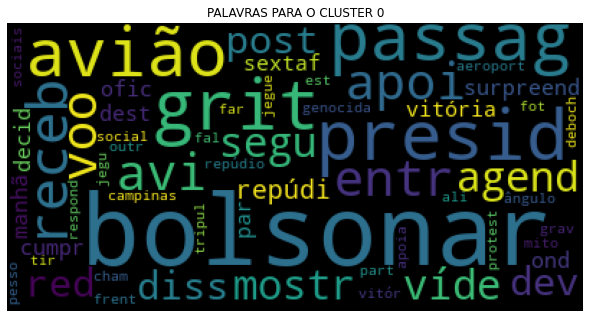

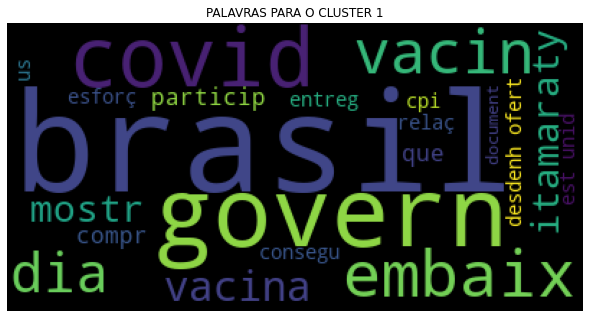

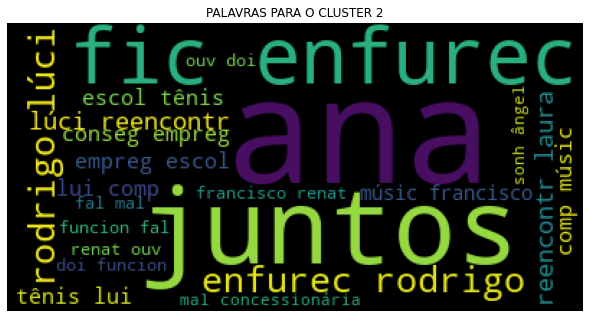

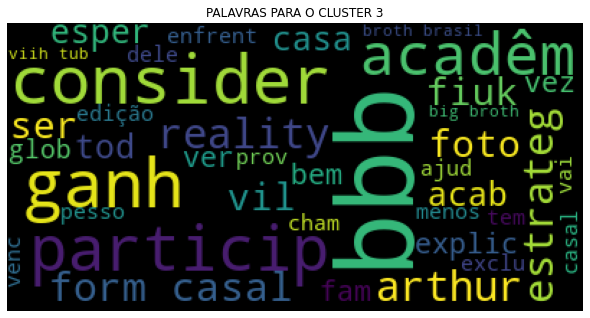

In [ ]:
for y in np.sort(dfDados['y_pred'].unique()):
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),100,str(y))

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
Z = hierarchy.linkage(model.children_, 'ward')
plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)